In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function # if you are using Python 2
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from classify_digits import *

In [3]:
n_samples = 10000

# Load the extracted topological features

In [4]:
X = np.load('../data/features_'+ str(n_samples) + '.npy', allow_pickle=True)
y = np.load('../data/y_' + str(n_samples) + '.npy', allow_pickle=True)

# we are cheating a bit in scaling all of the data, instead of fitting
# the transformation on training set and applying it on test set
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split 50:50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
print('Number of samples in train set: %i' % (X_train.shape[0]) )
print('Number of samples in test set: %i' % (X_test.shape[0]) )

Number of samples in train set: 5000
Number of samples in test set: 5000


# Classify the images using SVM with RBF kernel

In [5]:
# perform the grid search
if n_samples > 1000: # it takes some time
    # The best parameter values are
    # {'C': 138.94954943731375, 'gamma': 0.006551285568595509}
    # with a score of 0.89
    # Accuracy: 0.8872
    values = {'C': 138.94954943731375, 'gamma': 0.006551285568595509}
else:
    C_range = np.logspace(0, 3, 50)
    gamma_range = np.logspace(-3, 1, 50)
    values = grid_search(X_train, y_train, C_range, gamma_range)

# Evaluate the model

## Results of 10-fold CV results on train set

In [6]:
classifier = svm.SVC(C=values['C'], gamma=values['gamma'])
scores = cross_val_score(classifier, X_train, y_train, cv=10)
print('Accuracy on the train set: %0.2f (+/- %0.2f)' %
     (scores.mean(), scores.std() * 2))

Accuracy on the train set: 0.88 (+/- 0.05)


## Results on test set

In [7]:
classifier.fit(X_train, y_train) # train the model on train set

SVC(C=138.949549437, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0065512855686,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
predicted = classifier.predict(X_test) # predict on test set

In [9]:
print('Accuracy on test set: %0.2f' %
      metrics.accuracy_score(y_test, predicted))

Accuracy on test set: 0.89


In [10]:
print('Classification results on test set:\n%s' %
      metrics.classification_report(y_test, predicted))

Classification results on test set:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       522
           1       0.94      0.96      0.95       564
           2       0.81      0.80      0.80       503
           3       0.94      0.86      0.89       539
           4       0.89      0.93      0.91       445
           5       0.74      0.75      0.75       429
           6       0.94      0.93      0.93       513
           7       0.84      0.89      0.87       520
           8       0.88      0.85      0.87       482
           9       0.92      0.91      0.92       483

   micro avg       0.89      0.89      0.89      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.89      0.89      0.89      5000



In [11]:
print('Confusion matrix on test set:\n%s' %
      metrics.confusion_matrix(y_test, predicted))

Confusion matrix on test set:
[[505   0   0   0   3   1   3   0  10   0]
 [  0 542   7   0   3   4   4   4   0   0]
 [  3   7 401   2   2  61   6  13   7   1]
 [  3   1  13 462   1  22   2  22   9   4]
 [  3   2  10   0 412   1   3   3   3   8]
 [  3   8  32  14   0 323   6  36   4   3]
 [  0   7  11   0   3   3 476   0  12   1]
 [  0   3  16  14   3  16   0 463   1   4]
 [ 14   1   7   0  21   3   8   0 412  16]
 [  1   5   1   2  17   1   0   8   8 440]]


# Examples of misclassified images

From the confusion matrix on test set we see that there were 3 examples of 2 being mistaken for number 0 when number 2 was written with a loop:

Image of 2 was misclassified as: 0


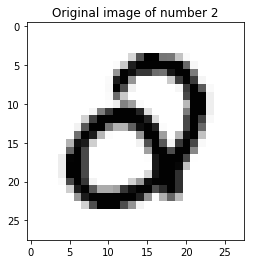

Image of 2 was misclassified as: 0


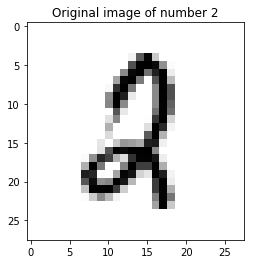

Image of 2 was misclassified as: 0


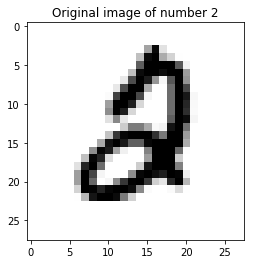

In [12]:
show_misclassified(classifier, X_test, y_test, 
                   actual=2, mistaken_for=0)

For number 5 we got the lowest F1 score of 0.75. It was misclassified as 2 in 32 examples in test set. Expected since these numbers are topologically the same when number 2 is written with no
loop. (Number 5 looks similar to number 2 if we reflect it vertically and horizontally.)

Image of 5 was misclassified as: 2


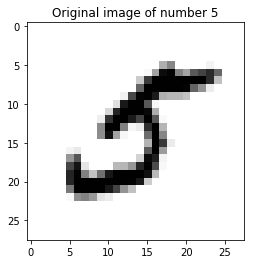

Image of 5 was misclassified as: 2


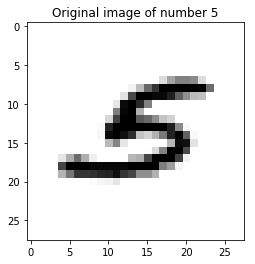

Image of 5 was misclassified as: 2


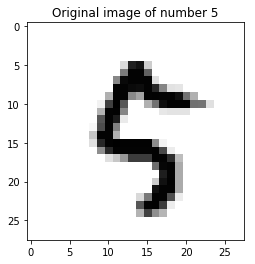

In [13]:
show_misclassified(classifier, X_test, y_test,
                   actual=5, mistaken_for=2)

Number 8 was misclassfied as 4 in 21 examples from test set. After inspecting the examples we see the stylistic problems that caused the topological changes. The top loop of number 8 was not closed which made it topologically more similar to number 4 written with a loop:

Image of 8 was misclassified as: 4


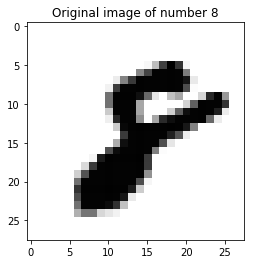

Image of 8 was misclassified as: 4


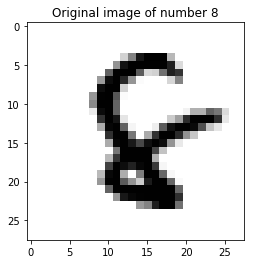

Image of 8 was misclassified as: 4


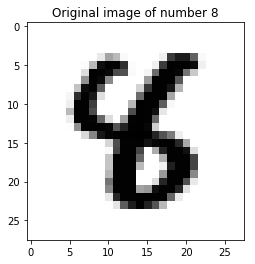

In [14]:
show_misclassified(classifier, X_test, y_test, 
                   actual=8, mistaken_for=4)